In [2]:
import numpy as np
import matplotlib.pyplot as pl
import os, sys
import glob
import cv2
from PIL import Image

Establecemos la GPU a usar

In [3]:
 os.environ["CUDA_VISIBLE_DEVICES"]="0"

La ruta donde están las imágenes (en jpeg). Están bajadas de: https://zenodo.org/records/1214456#.XV2cJeg3lhF (parte de la NCT-CRC-HE-100K-NONORM)

In [4]:
path = "./PAT/*.jpg"
#path = "/scratch1/westend/Pato/pred_silvia/PAT/*.jpg"

In [5]:
im_files=sorted(glob.glob(path))
print(im_files)

['/scratch1/westend/Pato/pred_silvia/PAT/NORM-AAGILIQR.jpg', '/scratch1/westend/Pato/pred_silvia/PAT/NORM-ACDPMDCY.jpg', '/scratch1/westend/Pato/pred_silvia/PAT/NORM-ACDTPANR.jpg', '/scratch1/westend/Pato/pred_silvia/PAT/NORM-ACENLWHV.jpg', '/scratch1/westend/Pato/pred_silvia/PAT/NORM-ACRPSRME.jpg', '/scratch1/westend/Pato/pred_silvia/PAT/NORM-ADQPVTAC.jpg', '/scratch1/westend/Pato/pred_silvia/PAT/NORM-ADVQQFTS.jpg', '/scratch1/westend/Pato/pred_silvia/PAT/NORM-ADWTDWQC.jpg', '/scratch1/westend/Pato/pred_silvia/PAT/NORM-AEAYLVED.jpg', '/scratch1/westend/Pato/pred_silvia/PAT/NORM-AEEKTADL.jpg', '/scratch1/westend/Pato/pred_silvia/PAT/TUM-AAHVWQSR.jpg', '/scratch1/westend/Pato/pred_silvia/PAT/TUM-AAMWAKSK.jpg', '/scratch1/westend/Pato/pred_silvia/PAT/TUM-AASNAVGE.jpg', '/scratch1/westend/Pato/pred_silvia/PAT/TUM-ACAWGFMV.jpg', '/scratch1/westend/Pato/pred_silvia/PAT/TUM-ACDKMPEH.jpg', '/scratch1/westend/Pato/pred_silvia/PAT/TUM-ACEMMVCS.jpg', '/scratch1/westend/Pato/pred_silvia/PAT/TUM-A

Leo las imagenes sin procesar, y como las necesita la NN para predecir (normalizaadas y escaladas a 299x299 y los canales en orden tipo cv2)

In [6]:
image_orig = []
image_proc = []
for file in im_files:
    image_raw = np.array(Image.open(file))
    image_raw = image_raw[:, :, (2, 1, 0)]
    image_orig.append(image_raw)
    image_raw = ((image_raw / 255.0)-0.5)*2
    image_raw = cv2.resize(image_raw, (299, 299))
    image_proc.append(image_raw)

image_proc = np.array(image_proc)

/scratch1/westend/Pato/pred_silvia/PAT/NORM-ACDPMDCY.jpg
(224, 224, 3)


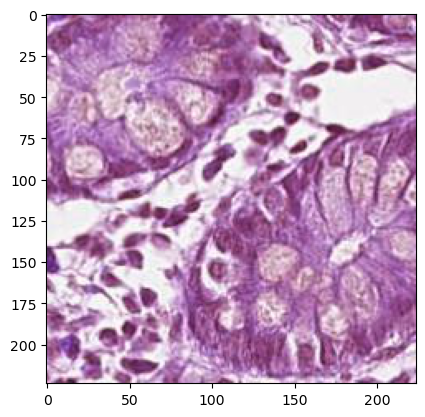

In [7]:
print(im_files[1])
print(image_orig[1].shape)
pl.imshow(image_orig[1])

Establezco la ruta al modelo, lo importo y cargo los pesos:

In [8]:
path_modelo = "./modelos/Yu_meancher_model"
#path_modelo = "/scratch1/westend/Pato/pred_silvia/patomat_231_limpio/portaanalysis/portaanalysis/patchprediction/Yu_meancher_model"
sys.path.insert(0,path_modelo)
from models_mini import MeanTeacherModel
model = MeanTeacherModel() 

# Bajarse los pesos del cloud (son muy grandes para github)
model_path= os.path.join(path_modelo,'Model-0.1-SSL-0.hdf5')
model.loadWeights(model_path)

2024-01-11 12:51:55.756811: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-11 12:51:55.951469: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-11 12:51:55.953960: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-11 12:51:58.765652: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-01-11 12:52:01.608710: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gp

True

Hago las predicciones sobre el batch de imágenes:

In [9]:
pred = model.predict(image_proc)

1/1 [==============================] - 9s 9s/step


La predicciones son de los modelos student/teacher (4 elementos). 
Como criterio elegimos que el segundo sea mayor que 0.5 (tumoral) y si es menor que 0.5 sea no-tumoral (o normal).

In [14]:
print(pred[1])
print(pred[1][1] > 0.5)

[9.9991411e-01 8.5787353e-05 9.9999827e-01 1.7185583e-06]
False


Vemos un ejemplo tumoral:

/scratch1/westend/Pato/pred_silvia/PAT/TUM-AAHVWQSR.jpg


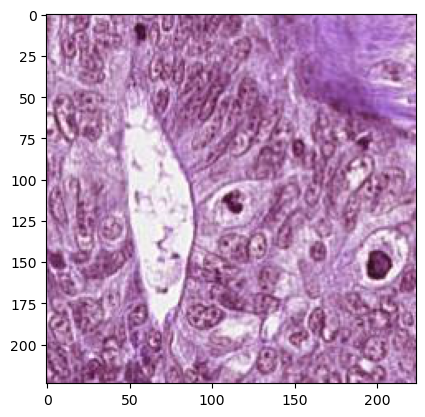

In [11]:
print(im_files[10])
pl.imshow(image_orig[10])

La detección:

In [15]:
print(pred[10])
print(pred[10][1] > 0.5)

[0.02529148 0.9747085  0.44841936 0.5515806 ]
True
